In [10]:
!pip install kaggle
!pip install torch torchvision torchmetrics timm

In [11]:
from google.colab import files
files.upload()

{}

In [3]:
import os
os.makedirs('~/.kaggle', exist_ok=True)  # Membuat folder .kaggle
!cp kaggle.json ~/.kaggle/  # Menyalin kaggle.json ke folder .kaggle
!chmod 600 ~/.kaggle/kaggle.json  # Mengubah izin file agar aman
!kaggle datasets download -d himanshuydv11/facial-emotion-dataset
!unzip facial-emotion-dataset.zip -d ./facial_emotion_data/

# Menampilkan struktur folder
dataset_dir = './facial_emotion_data/facial_emotion_dataset/'
for subdir, dirs, files in os.walk(dataset_dir):
    print(f"Subdirectory: {subdir}")
    for file in files:
        print(f" - {file}")


Streaming output truncated to the last 5000 lines.
 - cropped_emotions.505334~angry.png
 - 859cb49252673b939e547a34ebaed9b72d0a12065f3bb39b4db96597~angry.jpg
 - cropped_emotions.231714~angry.png
 - cropped_emotions.231899~angry.png
 - cropped_emotions.232242~angry.png
 - cropped_emotions.571846~angry.png
 - cropped_emotions.232256~angry.png
 - cropped_emotions.231661~angry.png
 - cropped_emotions.506180~angry.png
 - 1e8696e74a10ae478be830bb4a240460a5982ba94beda0aa4c152eac~angry.jpeg
 - cropped_emotions.231936~angry.png
 - cropped_emotions.231435~angry.png
 - fd7a662f62d84c58378b592b8f7cdde4e004c18f70c39e60efe6d1d6~angry.jpg
 - cropped_emotions.158009~angry.png
 - cropped_emotions.506260~angry.png
 - 0bd898fb3a08efc6815bc18de51141d8242b0b2595a482135d8ea6fb~angry.jpg
 - cropped_emotions.571152~angry.png
 - cropped_emotions.231683~angry.png
 - cropped_emotions.505478~angry.png
 - cropped_emotions.157934~angry.png
 - cropped_emotions.232069~angry.png
 - cropped_emotions.505833~angry.png
 -

In [12]:
import os
import torch
import shutil
import numpy as np
from glob import glob
from PIL import Image
from torch.utils.data import random_split, Dataset, DataLoader
from torchvision import transforms as T
torch.manual_seed(2024)

class CustomDataset(Dataset):
    def __init__(self, root, transformations=None):
        self.transformations = transformations
        self.im_paths = [im_path for im_path in sorted(glob(f"{root}/*/*"))]
        self.cls_names, self.cls_counts, count = {}, {}, 0

        for im_path in self.im_paths:
            class_name = self.get_class(im_path)
            if class_name not in self.cls_names:
                self.cls_names[class_name] = count
                self.cls_counts[class_name] = 1
                count += 1
            else:
                self.cls_counts[class_name] += 1

    def get_class(self, path):
        return os.path.dirname(path).split("/")[-1]

    def __len__(self):
        return len(self.im_paths)

    def __getitem__(self, idx):
        im_path = self.im_paths[idx]
        im = Image.open(im_path).convert("RGB")
        gt = self.cls_names[self.get_class(im_path)]

        if self.transformations is not None:
            im = self.transformations(im)

        return im, gt

def get_dls(root, transformations, bs, split=[0.9, 0.05, 0.05], ns=4):
    ds = CustomDataset(root=root, transformations=transformations)

    total_len = len(ds)
    tr_len = int(total_len * split[0])
    vl_len = int(total_len * split[1])
    ts_len = total_len - (tr_len + vl_len)

    tr_ds, vl_ds, ts_ds = random_split(dataset=ds, lengths=[tr_len, vl_len, ts_len])
    tr_dl = DataLoader(tr_ds, batch_size=bs, shuffle=True, num_workers=ns)
    val_dl = DataLoader(vl_ds, batch_size=bs, shuffle=False, num_workers=ns)
    ts_dl = DataLoader(ts_ds, batch_size=1, shuffle=False, num_workers=ns)

    return tr_dl, val_dl, ts_dl, ds.cls_names

root = "./facial_emotion_data/facial_emotion_dataset/dataset"
mean, std, im_size = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225], 224
tfs = T.Compose([T.Resize((im_size, im_size)), T.ToTensor(), T.Normalize(mean=mean, std=std)])
tr_dl, val_dl, ts_dl, classes = get_dls(root=root, transformations=tfs, bs=32)

print(len(tr_dl))
print(len(val_dl))
print(len(ts_dl))
print(classes)

435
25
774
{'Ahegao': 0, 'Angry': 1, 'Happy': 2, 'Neutral': 3, 'Sad': 4, 'Surprise': 5}


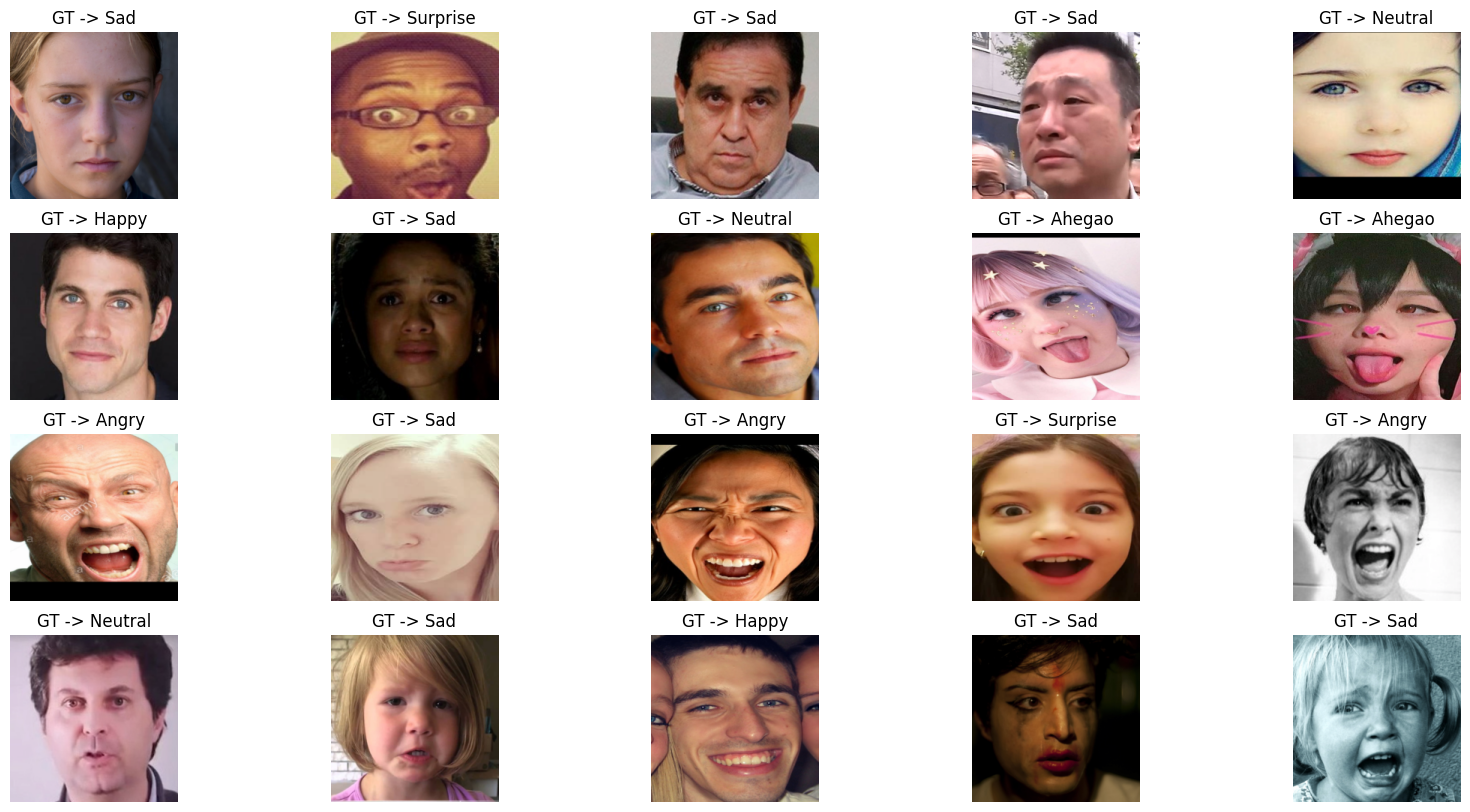

In [13]:
import random
from matplotlib import pyplot as plt

def tensor_2_im(t, t_type="rgb"):
    gray_tfs = T.Compose([T.Normalize(mean=[0.], std=[1/0.5]), T.Normalize(mean=[-0.5], std=[1])])
    rgb_tfs = T.Compose([T.Normalize(mean=[0., 0., 0.], std=[1/0.229, 1/0.224, 1/0.225]),
                         T.Normalize(mean=[-0.485, -0.456, -0.406], std=[1., 1., 1.])])

    invTrans = gray_tfs if t_type == "gray" else rgb_tfs
    return (invTrans(t) * 255).detach().cpu().permute(1, 2, 0).numpy().astype(np.uint8)

def visualize(data, n_ims, rows, cmap=None, cls_names=None):
    assert cmap in ["rgb", "gray"], "Tentukan apakah gambar berwarna atau hitam-putih!"
    if cmap == "rgb":
        cmap = "viridis"

    plt.figure(figsize=(20, 10))
    indices = [random.randint(0, len(data) - 1) for _ in range(n_ims)]
    for idx, index in enumerate(indices):
        im, gt = data[index]
        plt.subplot(rows, n_ims // rows, idx + 1)
        plt.imshow(tensor_2_im(im, cmap) if cmap else tensor_2_im(im))
        plt.axis('off')
        if cls_names is not None:
            plt.title(f"GT -> {cls_names[int(gt)]}")
        else:
            plt.title(f"GT -> {gt}")

visualize(tr_dl.dataset, 20, 4, "rgb", list(classes.keys()))

<ipython-input-14-ddc533f63454>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(cls_names, rotation=60)


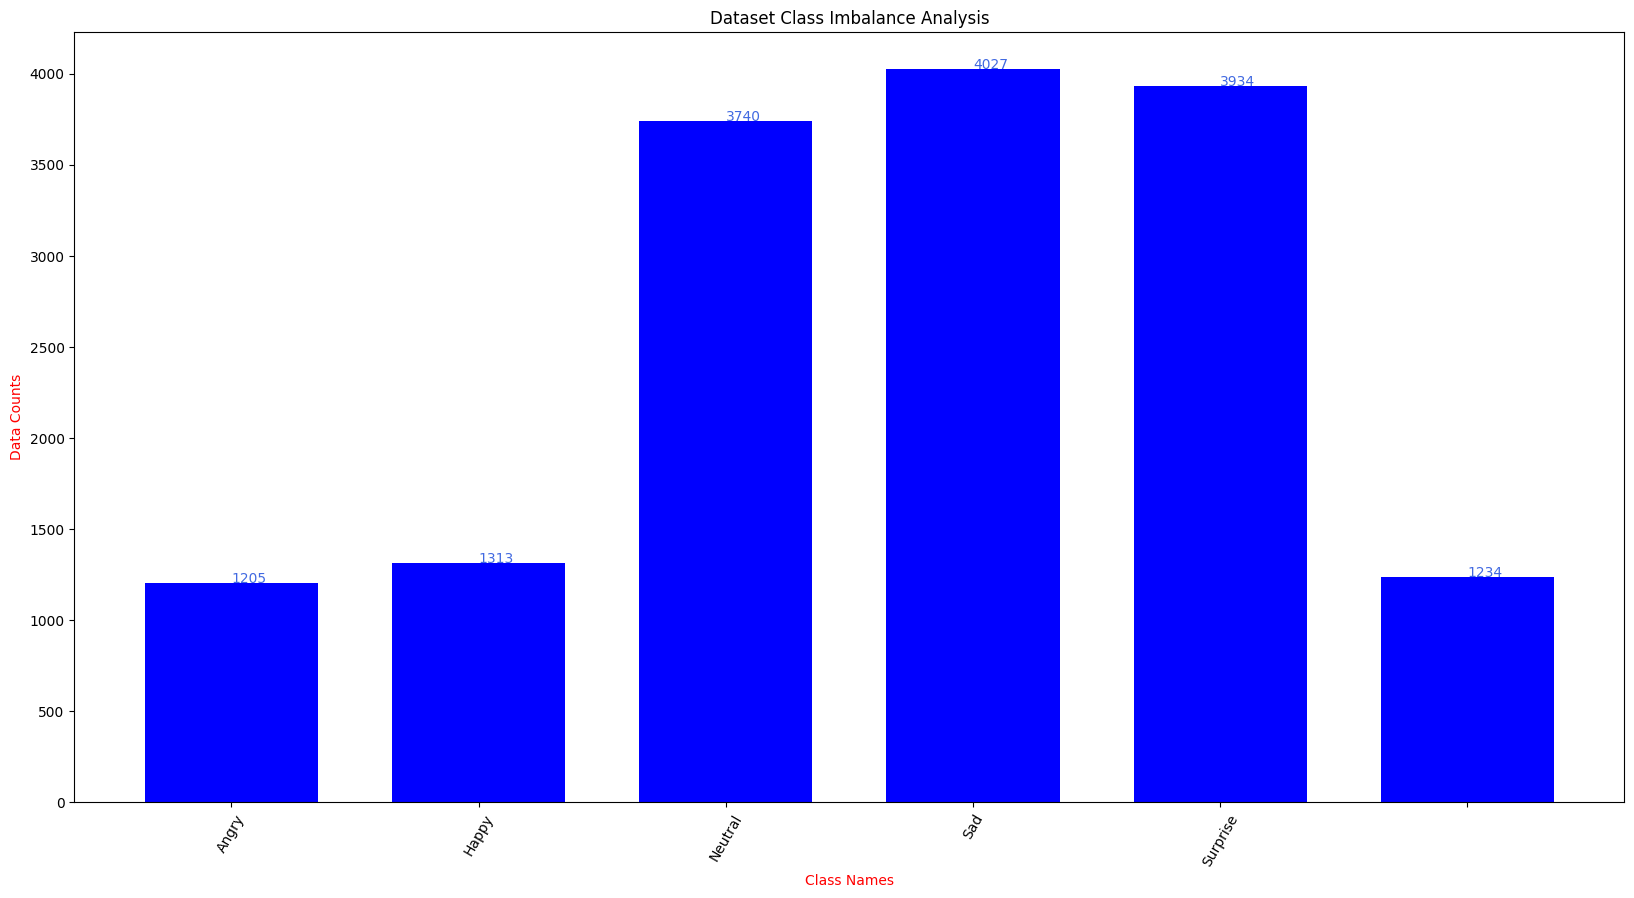

In [14]:
def data_analysis(root, transformations):
    ds = CustomDataset(root=root, transformations=transformations)
    cls_counts = ds.cls_counts
    cls_names = list(cls_counts.keys())
    counts = list(cls_counts.values())

    fig, ax = plt.subplots(figsize=(20, 10))
    indices = np.arange(len(counts))

    ax.bar(indices, counts, width=0.7, color="blue")
    ax.set_xlabel("Class Names", color="red")
    ax.set_xticklabels(cls_names, rotation=60)
    ax.set_ylabel("Data Counts", color="red")
    ax.set_title("Dataset Class Imbalance Analysis")

    for i, v in enumerate(counts):
        ax.text(i, v + 2, str(v), color="royalblue")

data_analysis(root=root, transformations=tfs)

In [15]:
import timm
import torchmetrics
from tqdm import tqdm

# Menggunakan model CNN yang lebih ringan dan efisien
m = timm.create_model("rexnet_150", pretrained=True, num_classes=len(classes))

def train_setup(m):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    return m.to(device), 20, device, torch.nn.CrossEntropyLoss(), torch.optim.Adam(params=m.parameters(), lr=3e-4)

def to_device(batch, device):
    return batch[0].to(device), batch[1].to(device)

def get_metrics(model, ims, gts, loss_fn, epoch_loss, epoch_acc, epoch_f1):
    preds = model(ims)
    loss = loss_fn(preds, gts)
    epoch_f1.update(preds.softmax(dim=1), gts)  # Update F1 score
    return loss, epoch_loss + loss.item(), epoch_acc + (torch.argmax(preds, dim=1) == gts).sum().item()

# Setup awal
m, epochs, device, loss_fn, optimizer = train_setup(m)
f1_score = torchmetrics.F1Score(task="multiclass", num_classes=len(classes)).to(device)

print("Mulai pelatihan...")

best_acc, best_loss = 0, float("inf")
tr_losses, val_losses, tr_accs, val_accs = [], [], [], []

for epoch in range(epochs):
    epoch_loss, epoch_acc = 0, 0
    for idx, batch in tqdm(enumerate(tr_dl)):
        ims, gts = to_device(batch, device)
        loss, epoch_loss, epoch_acc = get_metrics(m, ims, gts, loss_fn, epoch_loss, epoch_acc, f1_score)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    tr_loss_to_track = epoch_loss / len(tr_dl)
    tr_acc_to_track = epoch_acc / len(tr_dl.dataset)
    tr_losses.append(tr_loss_to_track)
    tr_accs.append(tr_acc_to_track)

    print(f"{epoch + 1}-epoch proses pelatihan selesai!")
    print(f"Loss pelatihan: {tr_loss_to_track:.3f}, Akurasi pelatihan: {tr_acc_to_track:.3f}")

    # Evaluasi pada data validasi
    m.eval()
    with torch.no_grad():
        val_epoch_loss, val_epoch_acc = 0, 0
        for idx, batch in enumerate(val_dl):
            ims, gts = to_device(batch, device)
            loss, val_epoch_loss, val_epoch_acc = get_metrics(m, ims, gts, loss_fn, val_epoch_loss, val_epoch_acc, f1_score)

        val_loss_to_track = val_epoch_loss / len(val_dl)
        val_acc_to_track = val_epoch_acc / len(val_dl.dataset)
        val_losses.append(val_loss_to_track)
        val_accs.append(val_acc_to_track)

        print(f"Loss validasi: {val_loss_to_track:.3f}, Akurasi validasi: {val_acc_to_track:.3f}")

        if val_loss_to_track < best_loss:
            best_loss = val_loss_to_track
            torch.save(m.state_dict(), f"best_model.pth")

    # Hitung F1 Score untuk epoch ini
    epoch_f1_score = f1_score.compute()
    print(f"F1 Score: {epoch_f1_score:.3f}")
    f1_score.reset()  # Reset F1 Score untuk epoch berikutnya

Mulai pelatihan...


435it [02:11,  3.32it/s]

1-epoch proses pelatihan selesai!
Loss pelatihan: 0.909, Akurasi pelatihan: 0.683


Loss validasi: 0.485, Akurasi validasi: 0.808
F1 Score: 0.690


435it [02:01,  3.58it/s]

2-epoch proses pelatihan selesai!
Loss pelatihan: 0.618, Akurasi pelatihan: 0.761


Loss validasi: 0.545, Akurasi validasi: 0.794
F1 Score: 0.762


435it [02:01,  3.57it/s]

3-epoch proses pelatihan selesai!
Loss pelatihan: 0.404, Akurasi pelatihan: 0.846


Loss validasi: 0.469, Akurasi validasi: 0.825
F1 Score: 0.845


435it [01:59,  3.64it/s]

4-epoch proses pelatihan selesai!
Loss pelatihan: 0.308, Akurasi pelatihan: 0.883


Loss validasi: 0.464, Akurasi validasi: 0.837
F1 Score: 0.880


435it [02:02,  3.56it/s]

5-epoch proses pelatihan selesai!
Loss pelatihan: 0.222, Akurasi pelatihan: 0.916


Loss validasi: 0.450, Akurasi validasi: 0.845
F1 Score: 0.912


435it [02:02,  3.55it/s]

6-epoch proses pelatihan selesai!
Loss pelatihan: 0.163, Akurasi pelatihan: 0.936


Loss validasi: 0.515, Akurasi validasi: 0.834
F1 Score: 0.931


435it [01:59,  3.64it/s]

7-epoch proses pelatihan selesai!
Loss pelatihan: 0.132, Akurasi pelatihan: 0.952


Loss validasi: 0.419, Akurasi validasi: 0.855
F1 Score: 0.947


435it [02:01,  3.58it/s]

8-epoch proses pelatihan selesai!
Loss pelatihan: 0.108, Akurasi pelatihan: 0.960


Loss validasi: 0.457, Akurasi validasi: 0.867
F1 Score: 0.955


435it [02:02,  3.57it/s]

9-epoch proses pelatihan selesai!
Loss pelatihan: 0.096, Akurasi pelatihan: 0.965


Loss validasi: 0.658, Akurasi validasi: 0.843
F1 Score: 0.959


435it [01:59,  3.63it/s]

10-epoch proses pelatihan selesai!
Loss pelatihan: 0.071, Akurasi pelatihan: 0.974


Loss validasi: 0.689, Akurasi validasi: 0.837
F1 Score: 0.967


435it [02:02,  3.55it/s]

11-epoch proses pelatihan selesai!
Loss pelatihan: 0.081, Akurasi pelatihan: 0.971


Loss validasi: 0.614, Akurasi validasi: 0.843
F1 Score: 0.965


435it [02:04,  3.48it/s]

12-epoch proses pelatihan selesai!
Loss pelatihan: 0.074, Akurasi pelatihan: 0.975


Loss validasi: 0.643, Akurasi validasi: 0.856
F1 Score: 0.969


435it [01:59,  3.63it/s]

13-epoch proses pelatihan selesai!
Loss pelatihan: 0.066, Akurasi pelatihan: 0.978


Loss validasi: 0.594, Akurasi validasi: 0.854
F1 Score: 0.971


435it [02:03,  3.51it/s]

14-epoch proses pelatihan selesai!
Loss pelatihan: 0.067, Akurasi pelatihan: 0.977


Loss validasi: 0.644, Akurasi validasi: 0.846
F1 Score: 0.970


435it [02:03,  3.53it/s]

15-epoch proses pelatihan selesai!
Loss pelatihan: 0.067, Akurasi pelatihan: 0.977


Loss validasi: 0.700, Akurasi validasi: 0.826
F1 Score: 0.970


435it [01:59,  3.64it/s]

16-epoch proses pelatihan selesai!
Loss pelatihan: 0.049, Akurasi pelatihan: 0.984


Loss validasi: 0.643, Akurasi validasi: 0.839
F1 Score: 0.976


435it [02:03,  3.53it/s]

17-epoch proses pelatihan selesai!
Loss pelatihan: 0.063, Akurasi pelatihan: 0.977


Loss validasi: 0.740, Akurasi validasi: 0.826
F1 Score: 0.969


435it [02:04,  3.49it/s]

18-epoch proses pelatihan selesai!
Loss pelatihan: 0.047, Akurasi pelatihan: 0.983


Loss validasi: 0.722, Akurasi validasi: 0.851
F1 Score: 0.976


435it [02:00,  3.60it/s]

19-epoch proses pelatihan selesai!
Loss pelatihan: 0.051, Akurasi pelatihan: 0.982


Loss validasi: 0.966, Akurasi validasi: 0.838
F1 Score: 0.974


435it [02:04,  3.49it/s]

20-epoch proses pelatihan selesai!
Loss pelatihan: 0.043, Akurasi pelatihan: 0.987


Loss validasi: 0.823, Akurasi validasi: 0.837
F1 Score: 0.979


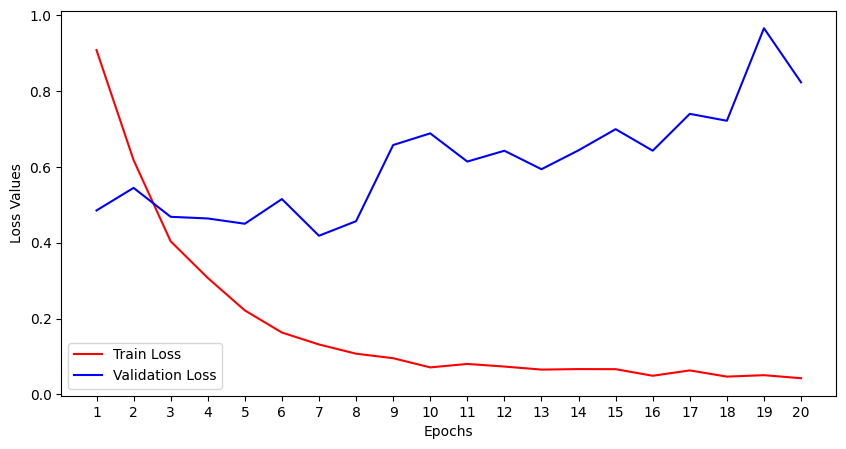

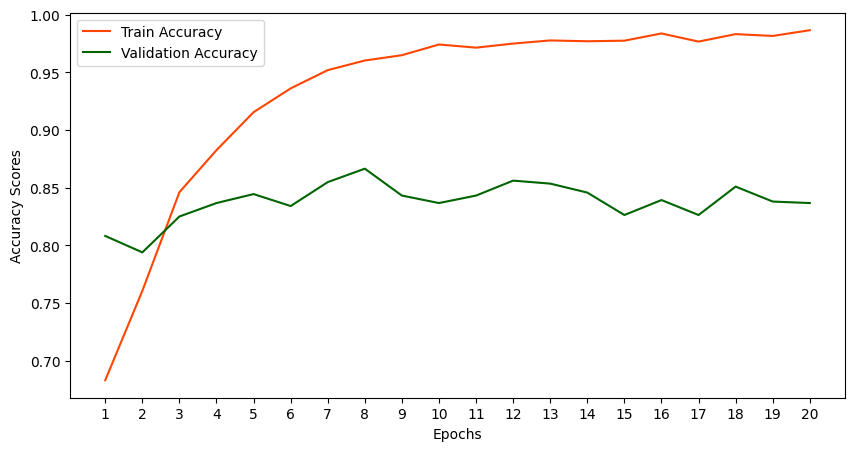

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import torch

class PlotLearningCurves:
    def __init__(self, tr_losses, val_losses, tr_accs, val_accs):
        self.tr_losses = tr_losses
        self.val_losses = val_losses
        self.tr_accs = tr_accs
        self.val_accs = val_accs

    def plot(self, array_1, array_2, label_1, label_2, color_1, color_2):
        plt.plot(array_1, label=label_1, color=color_1)
        plt.plot(array_2, label=label_2, color=color_2)

    def create_figure(self):
        plt.figure(figsize=(10, 5))

    def decorate(self, ylabel, xlabel="Epochs"):
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.xticks(ticks=np.arange(len(self.tr_accs)), labels=[i for i in range(1, len(self.tr_accs) + 1)])
        plt.legend()
        plt.show()

    def visualize(self):
        # Figure 1: Loss
        self.create_figure()
        self.plot(array_1=self.tr_losses, array_2=self.val_losses,
                  label_1="Train Loss", label_2="Validation Loss",
                  color_1="red", color_2="blue")
        self.decorate(ylabel="Loss Values")

        # Figure 2: Accuracy
        self.create_figure()
        self.plot(array_1=self.tr_accs, array_2=self.val_accs,
                  label_1="Train Accuracy", label_2="Validation Accuracy",
                  color_1="orangered", color_2="darkgreen")
        self.decorate(ylabel="Accuracy Scores")

# Setelah training selesai, panggil visualisasi
PlotLearningCurves(tr_losses, val_losses, tr_accs, val_accs).visualize()

100%|██████████| 25/25 [00:15<00:00,  1.65it/s]


Akurasi model pada data test: 0.855


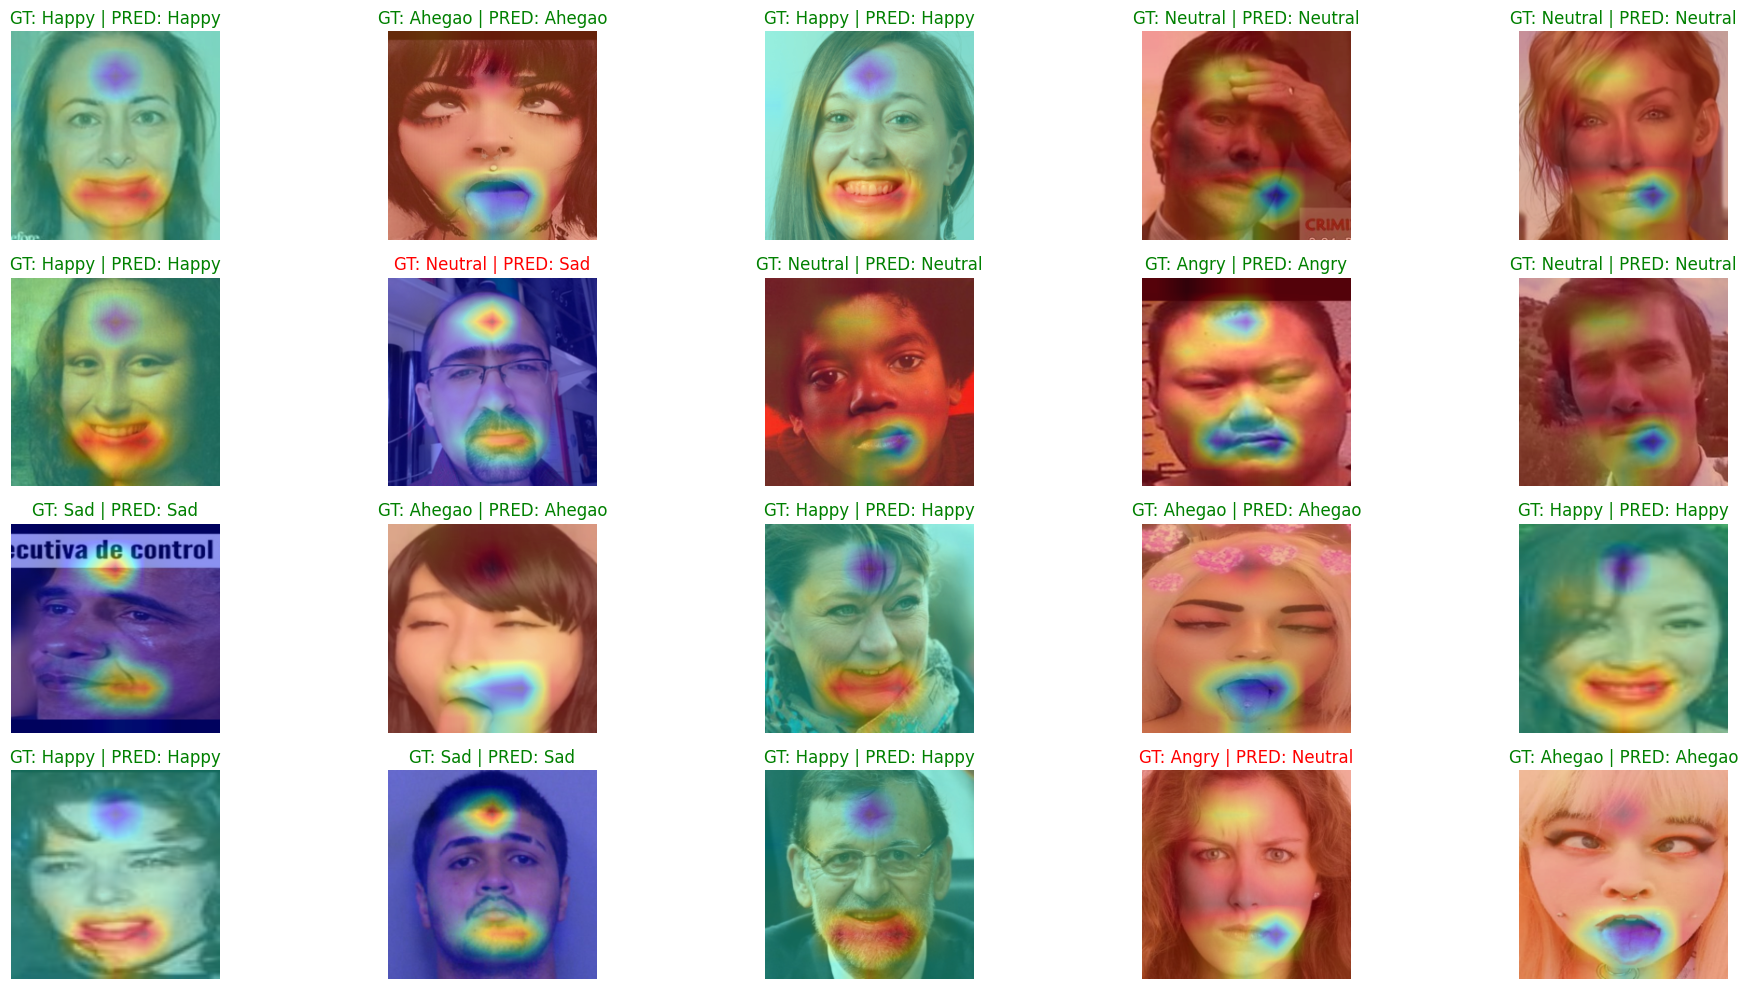

In [19]:
import cv2
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

class SaveFeatures():
    features = None
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_fn)

    def hook_fn(self, module, input, output):
        self.features = ((output.cpu()).data).numpy()

    def remove(self):
        self.hook.remove()

def getCAM(conv_fs, linear_weights, class_idx):
    bs, chs, h, w = conv_fs.shape
    cam = linear_weights[class_idx].dot(conv_fs[0,:, :, ].reshape((chs, h * w)))
    cam = cam.reshape(h, w)
    return (cam - np.min(cam)) / np.max(cam)

def tensor_2_im(tensor):
    # Normalisasi dan konversi tensor ke numpy array
    img = tensor.cpu().numpy().transpose(1, 2, 0)
    img = (img - img.min()) / (img.max() - img.min())
    return img

def inference(model, device, test_dl, num_ims, row, final_conv, fc_params, classes=None):
    weight, acc = np.squeeze(fc_params[0].cpu().data.numpy()), 0
    activated_features = SaveFeatures(final_conv)
    preds, images, lbls = [], [], []

    model.eval()
    with torch.no_grad():
        for batch in tqdm(test_dl):
            ims, gts = batch[0].to(device), batch[1].to(device)

            # Proses satu gambar pada satu waktu
            for im, gt in zip(ims, gts):
                im = im.unsqueeze(0)  # Tambahkan dimensi batch
                pred = model(im)
                pred_class = torch.argmax(pred, dim=1)

                acc += (pred_class == gt).item()
                images.append(im.squeeze())  # Simpan tanpa dimensi batch
                preds.append(pred_class.item())
                lbls.append(gt.item())

    print(f"Akurasi model pada data test: {(acc / len(test_dl.dataset)):.3f}")

    plt.figure(figsize=(20, 10))
    indices = [random.randint(0, len(images) - 1) for _ in range(num_ims)]

    for idx, index in enumerate(indices):
        im = images[index]
        pred_idx = preds[index]
        heatmap = getCAM(activated_features.features, weight, pred_idx)

        # Plot gambar
        plt.subplot(row, num_ims // row, idx + 1)
        plt.imshow(tensor_2_im(im))
        plt.axis("off")

        # Overlay heatmap
        im_size = im.shape[-1]
        plt.imshow(cv2.resize(heatmap, (im_size, im_size),
                            interpolation=cv2.INTER_LINEAR),
                  alpha=0.4, cmap='jet')
        plt.axis("off")

        # Menambahkan judul
        if classes is not None:
            gt_class = list(classes.keys())[lbls[index]]
            pred_class = list(classes.keys())[preds[index]]
            is_correct = gt_class == pred_class
            color = "green" if is_correct else "red"
            plt.title(f"GT: {gt_class} | PRED: {pred_class}",
                     color=color)
        else:
            plt.title(f"GT: {lbls[index]} | PRED: {preds[index]}")

    plt.tight_layout()
    plt.show()

# Memuat model yang telah dilatih
m.load_state_dict(torch.load("best_model.pth", weights_only=True))
m.eval()

# Mendapatkan layer konvolusi terakhir dan parameter fully connected
final_conv = m.features[-1]
fc_params = list(m.head.parameters())

# Menjalankan visualisasi
inference(model=m.to(device),
         device=device,
         test_dl=val_dl,
         num_ims=20,
         row=4,
         final_conv=final_conv,
         fc_params=fc_params,
         classes=classes)